In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier

# Step 1: Load dataset
# sampling to run the models faster
df = pd.read_csv("DataCo.csv", encoding="ISO-8859-1", nrows=5000)

In [2]:
# this the same data set but without sampling just to visualize the distributions
data = pd.read_csv("DataCo.csv", encoding="ISO-8859-1")

In [3]:
# Step 2: Create and store delivery delay before dropping it later
df['delivery_delay'] = (df['Days for shipping (real)'] - df['Days for shipment (scheduled)']).clip(lower=0)
df['is_late'] = (df['delivery_delay'] > 0).astype(int)

# ✅ Save a safe copy
delivery_delay_copy = df['delivery_delay'].copy()



In [4]:
# Step 3: Feature engineering
df['discount_ratio'] = df['Order Item Discount'] / (df['Order Item Product Price'] + 1e-6)
df['is_heavy_order'] = (df['Order Item Quantity'] > df['Order Item Quantity'].median()).astype(int)\
# High Margin Indicator
df['high_margin'] = (df['Benefit per order'] > df['Benefit per order'].median()).astype(int)

In [5]:
# Step 4: Estimate carbon footprint
emission_rate = {
    'Standard Class': 0.20,
    'Second Class': 0.25,
    'First Class': 0.35,
    'Same Day': 0.80
}
df['carbon_footprint'] = df['Shipping Mode'].map(emission_rate).fillna(0.2) * df['Order Item Quantity']

In [6]:
delivery_delay_series = df['delivery_delay'].copy()  # save a clean copy


In [7]:
# Step 5: Drop irrelevant or raw columns
drop_cols = [
    'Days for shipping (real)', 'Days for shipment (scheduled)', 'delivery_delay',
    'Order Item Discount', 'Order Item Product Price', 'Order Item Quantity',
    'Order Date (DateOrders)', 'Shipping Date (DateOrders)', 'Customer Id',
    'Customer Email', 'Customer Phone', 'Product Name', 'Product Status'
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [8]:
# Step 6: Reduce cardinality of categorical variables
def reduce_cardinality(series, top_n=10):
    top = series.value_counts().nlargest(top_n).index
    return series.where(series.isin(top), other='Other')

for col in df.select_dtypes(include='object').columns:
    df[col] = reduce_cardinality(df[col])

df = df[[col for col in df.columns if df[col].nunique() < 100]]

In [9]:
# Step 7: One-hot encode categorical features
df_encoded = pd.get_dummies(df)


In [10]:
# Step 8: Split features and target
X = df_encoded.drop(columns='is_late')
y = df_encoded['is_late']

In [11]:
# Step 9: Clean and handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.loc[:, X.isnull().mean() < 0.3]
df_final = pd.concat([X, y], axis=1).dropna()
X = df_final.drop(columns='is_late')
y = df_final['is_late']

In [12]:
# Step 10: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Step 11: Train XGBoost classifier
clf = XGBClassifier(
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    n_estimators=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf.fit(X_train, y_train)


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [14]:
# Step 12: Evaluate model
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("=== Disruption Prediction Model Metrics ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"AUC      : {roc_auc_score(y_test, y_proba):.4f}")


=== Disruption Prediction Model Metrics ===
Accuracy : 0.9790
Precision: 0.9907
Recall   : 0.9707
AUC      : 0.9990


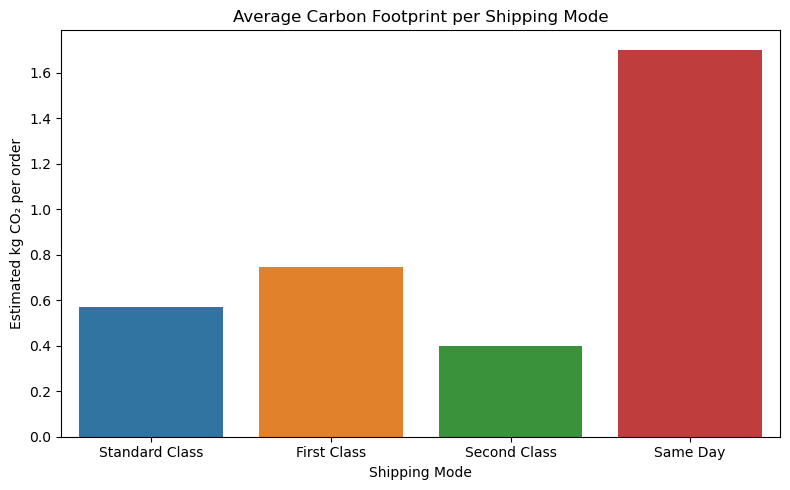

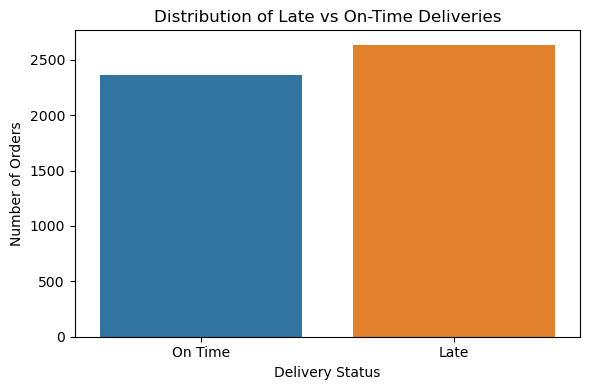

In [15]:
# Step 13: Visualizations
# A. Carbon footprint by shipping mode
plt.figure(figsize=(8, 5))
sns.barplot(x='Shipping Mode', y='carbon_footprint', data=df, estimator=np.mean, ci=None)
plt.title("Average Carbon Footprint per Shipping Mode")
plt.ylabel("Estimated kg CO₂ per order")
plt.xlabel("Shipping Mode")
plt.tight_layout()
plt.savefig("carbon_footprint_by_mode.png")
plt.show()

# B. Class distribution: late vs on-time
plt.figure(figsize=(6, 4))
sns.countplot(x='is_late', data=df)
plt.title("Distribution of Late vs On-Time Deliveries")
plt.xticks([0, 1], ['On Time', 'Late'])
plt.xlabel("Delivery Status")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.savefig("late_vs_ontime.png")
plt.show()

In [16]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, roc_auc_score
)
import numpy as np

def evaluate_model(y_true, y_pred, y_proba=None, task='classification'):
    if task == 'regression':
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        print("=== Regression Model Evaluation ===")
        print(f"MAE  : {mae:.4f}")
        print(f"RMSE : {rmse:.4f}")
        print(f"R²   : {r2:.4f}")

    elif task == 'classification':
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

        print("=== Classification Model Evaluation ===")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        if auc is not None:
            print(f"AUC      : {auc:.4f}")
    else:
        raise ValueError("Task must be 'regression' or 'classification'")


In [17]:
evaluate_model(y_test, y_pred, y_proba, task='classification')


=== Classification Model Evaluation ===
Accuracy : 0.9790
Precision: 0.9907
Recall   : 0.9707
AUC      : 0.9990


In [18]:
evaluate_model(y_test, y_pred, task='regression')


=== Regression Model Evaluation ===
MAE  : 0.0210
RMSE : 0.1449
R²   : 0.9153


In [19]:
# Restore 'delivery_delay' before modeling
df_final['delivery_delay'] = delivery_delay_copy.loc[df_final.index]


In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create regression target
y_delay = df_final['delivery_delay']  # original delay in days
X_reg = df_final.drop(columns=['is_late', 'delivery_delay'])

# Split regression data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_delay, test_size=0.2, random_state=42)

# Train the regression model
regressor = XGBRegressor(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
regressor.fit(X_train_r, y_train_r)

# Predict and evaluate
y_pred_r = regressor.predict(X_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)
mae = mean_absolute_error(y_test_r, y_pred_r)

print("=== Regression Model Metrics ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


=== Regression Model Metrics ===
MAE  : 0.3387
RMSE : 0.5478
R²   : 0.7414


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, feature_names, top_n=15, title="Top Feature Importances"):
    # Get feature importances from model
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort and plot top N
    top_features = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(title)
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


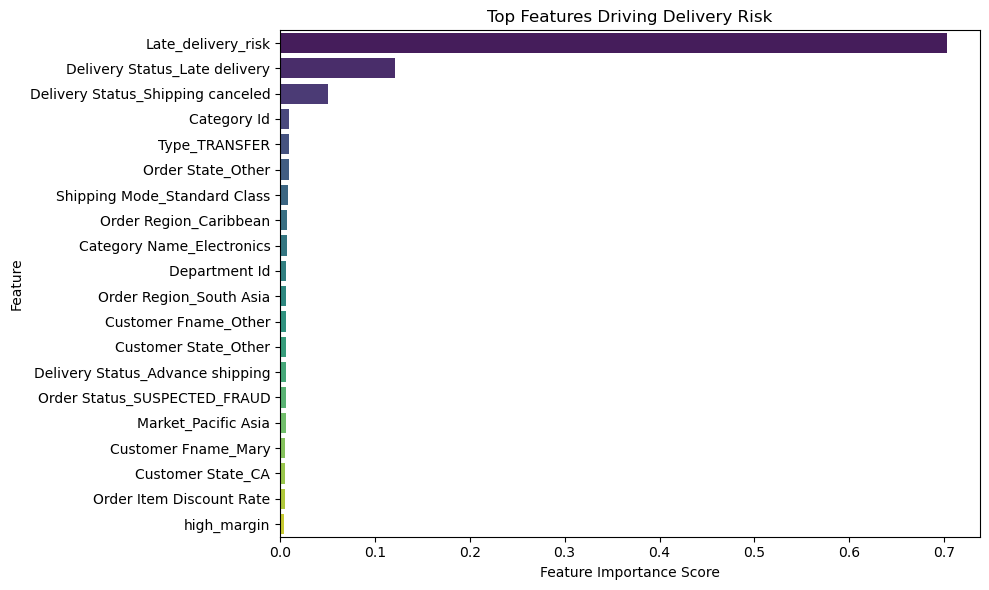

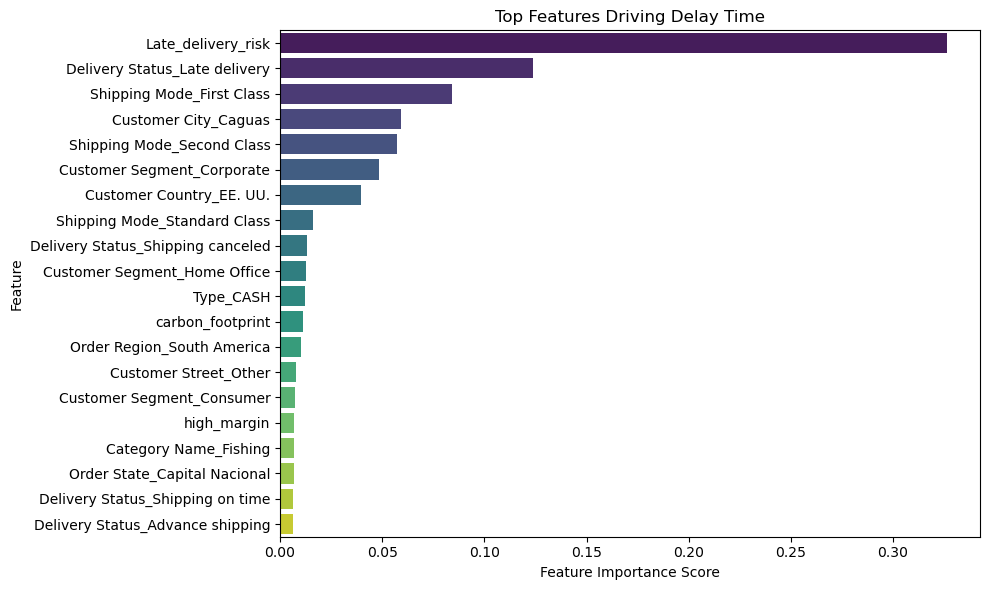

In [22]:
# For classification
plot_feature_importance(clf, X_train.columns, top_n=20, title="Top Features Driving Delivery Risk")

# For regression
plot_feature_importance(regressor, X_train.columns, top_n=20, title="Top Features Driving Delay Time")


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


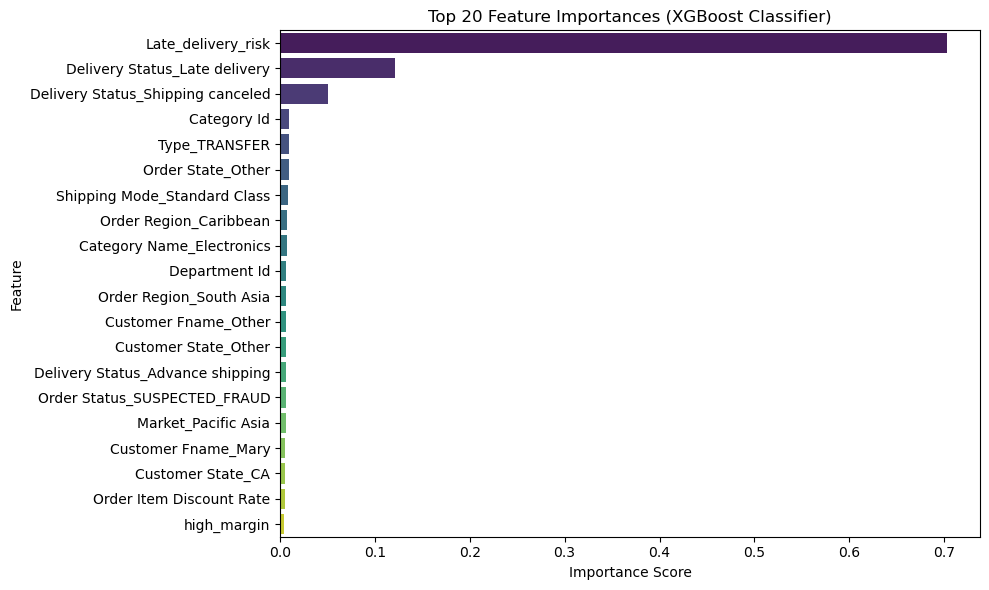

In [23]:
# Train XGBoost Classifier
clf = XGBClassifier(
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    n_estimators=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf.fit(X_train, y_train)

# Feature Importance Plot
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (XGBoost Classifier)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("top_feature_importance.png")
plt.show()


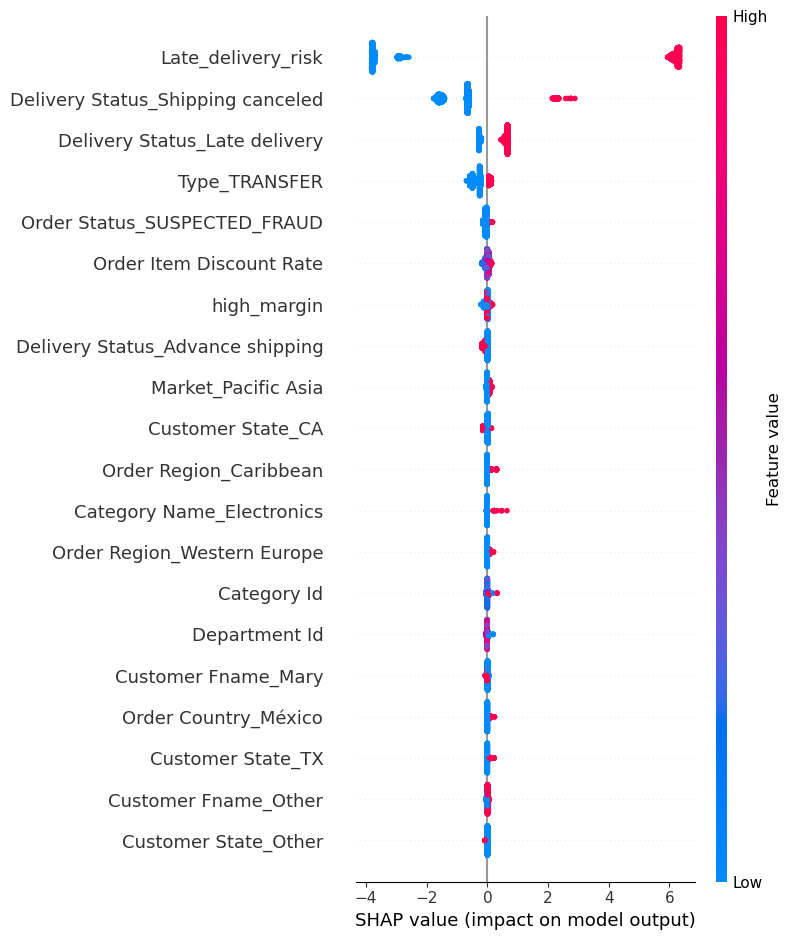

In [24]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [25]:
# Load your dataset
df = pd.read_csv("DataCo.csv", encoding="ISO-8859-1", nrows=5000)

# Print all column names to check
print(df.columns.tolist())


['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status', 'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Description', 'Product Image', 'Product Name', 'Product Price', 'Product Status', 'shipping date (DateOrde

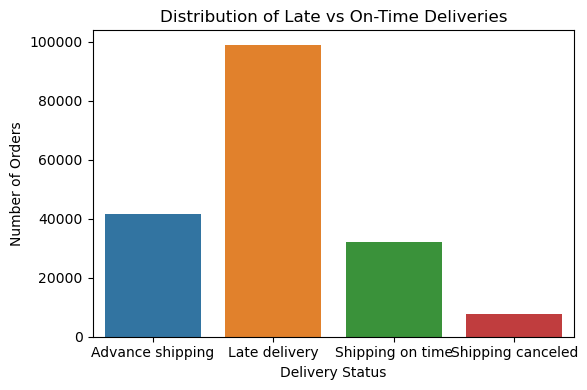

In [26]:
# Late vs On-Time Deliveries (Bar Plot)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='Delivery Status', data=data)
plt.title("Distribution of Late vs On-Time Deliveries")
plt.xlabel("Delivery Status")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


In [27]:
# Carbon Footprint by Shipping Mode (Bar Plot)
# Estimate carbon footprint
emission_rate = {
    'Standard Class': 0.20,
    'Second Class': 0.25,
    'First Class': 0.35,
    'Same Day': 0.80
}
df['carbon_footprint'] = df['Shipping Mode'].map(emission_rate).fillna(0.2) * df['Order Item Quantity']



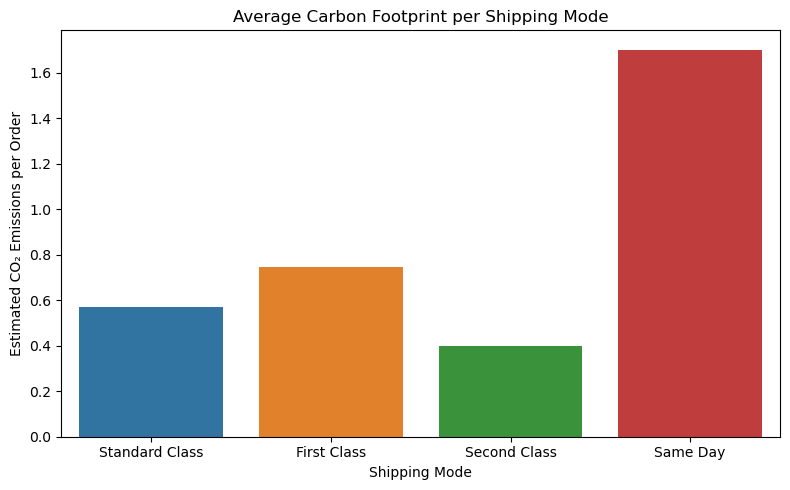

In [28]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Shipping Mode', y='carbon_footprint', data=df, estimator=np.mean, ci=None)
plt.title("Average Carbon Footprint per Shipping Mode")
plt.ylabel("Estimated CO₂ Emissions per Order")
plt.xlabel("Shipping Mode")
plt.tight_layout()
plt.show()


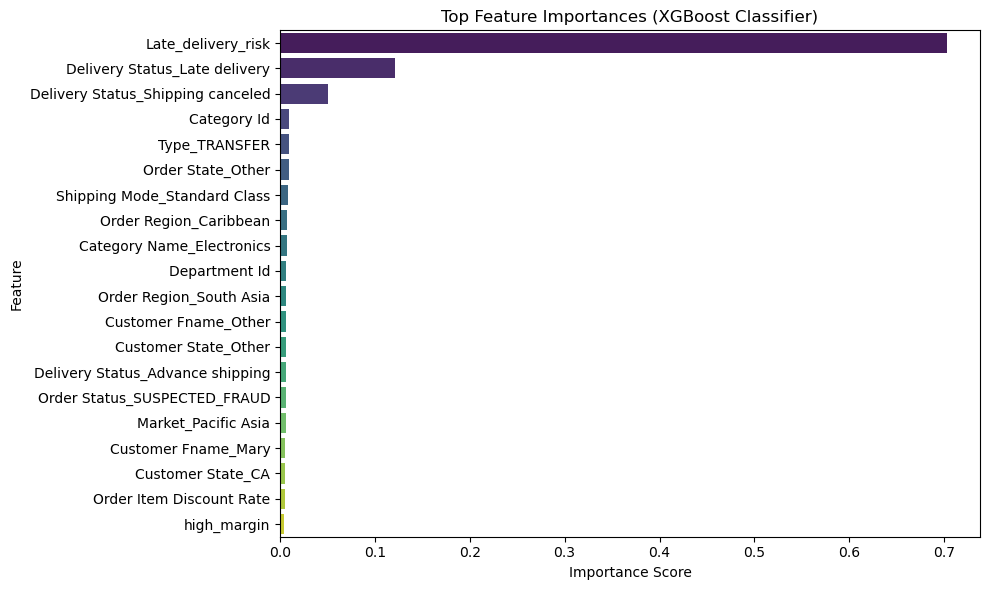

In [29]:
# Top Feature Importances (After Model)

import pandas as pd

feature_importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top Feature Importances (XGBoost Classifier)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


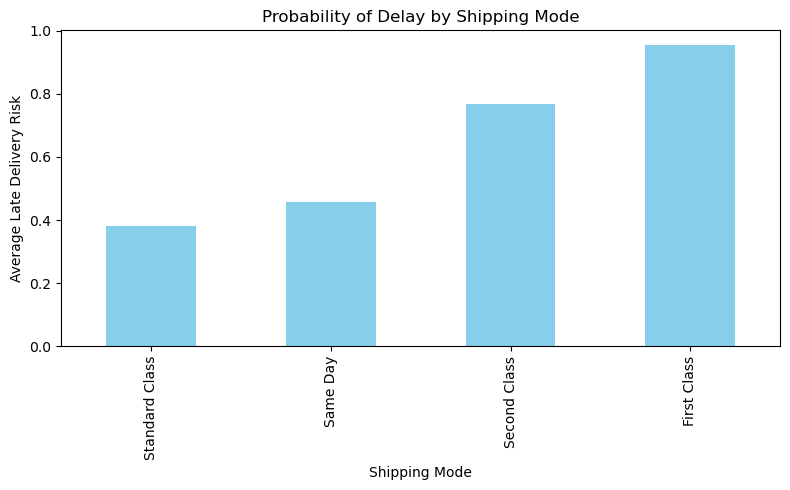

In [30]:
# Shipping Mode vs Delay Probability (Bar Plot)

plt.figure(figsize=(8, 5))
shipping_delay = data.groupby('Shipping Mode')['Late_delivery_risk'].mean().sort_values()
shipping_delay.plot(kind='bar', color='skyblue')
plt.title("Probability of Delay by Shipping Mode")
plt.ylabel("Average Late Delivery Risk")
plt.xlabel("Shipping Mode")
plt.tight_layout()
plt.show()


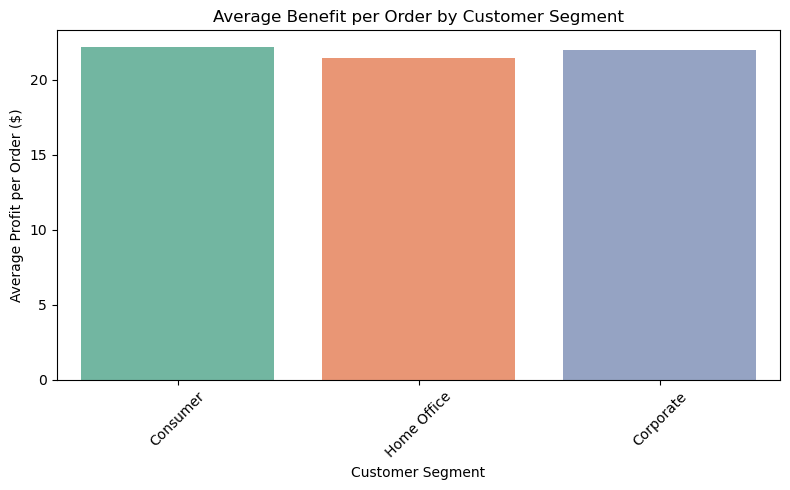

In [31]:
# Benefit per Order by Customer Segment (Bar Plot)

plt.figure(figsize=(8, 5))
sns.barplot(x='Customer Segment', y='Benefit per order', data=data, estimator=np.mean, ci=None, palette='Set2')
plt.title("Average Benefit per Order by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Average Profit per Order ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


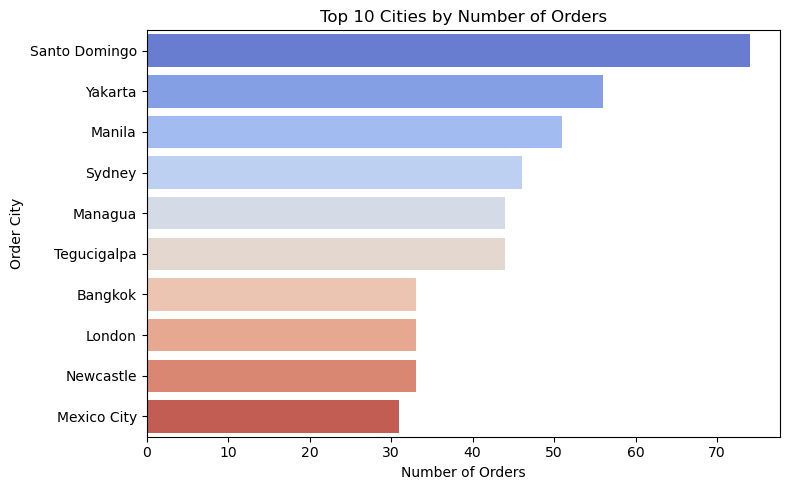

In [32]:
# Top 10 Order Cities (Bar Plot)

top_cities = df['Order City'].value_counts().nlargest(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_cities.values, y=top_cities.index, palette='coolwarm')
plt.title("Top 10 Cities by Number of Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Order City")
plt.tight_layout()
plt.show()


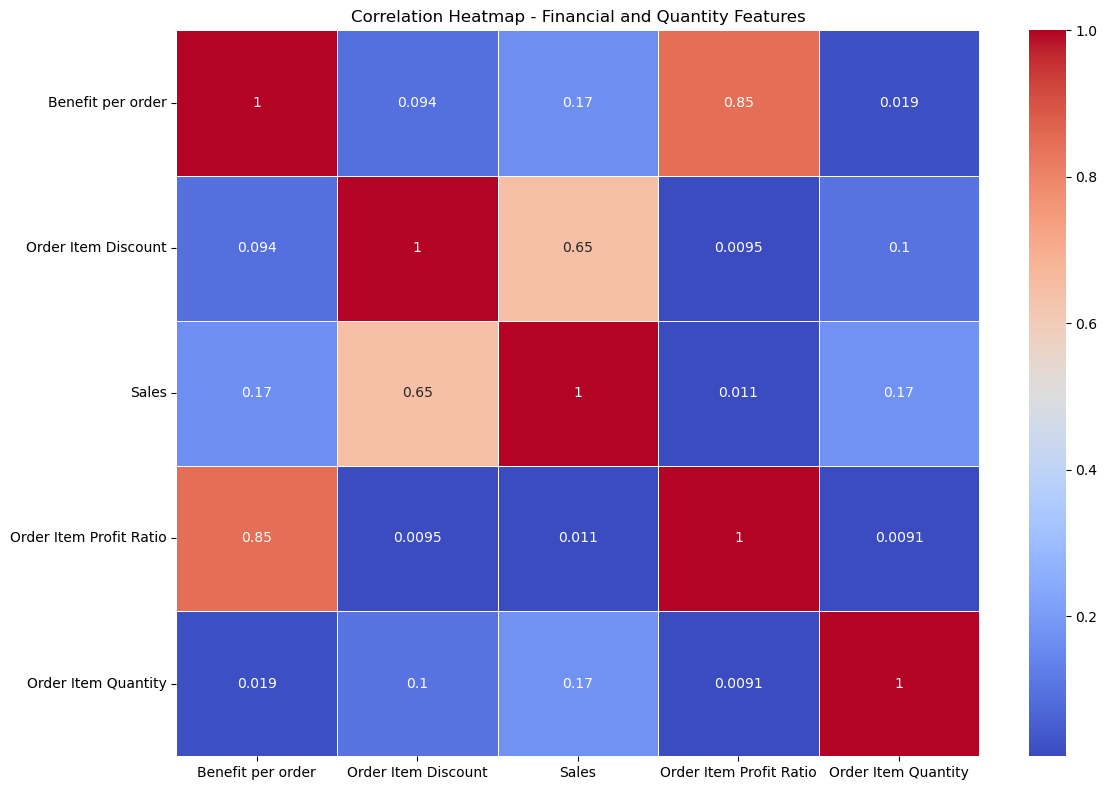

In [33]:
# Correlation Heatmap (Numeric Features)

plt.figure(figsize=(12, 8))
corr = df[['Benefit per order', 'Order Item Discount', 'Sales', 'Order Item Profit Ratio', 'Order Item Quantity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap - Financial and Quantity Features")
plt.tight_layout()
plt.show()


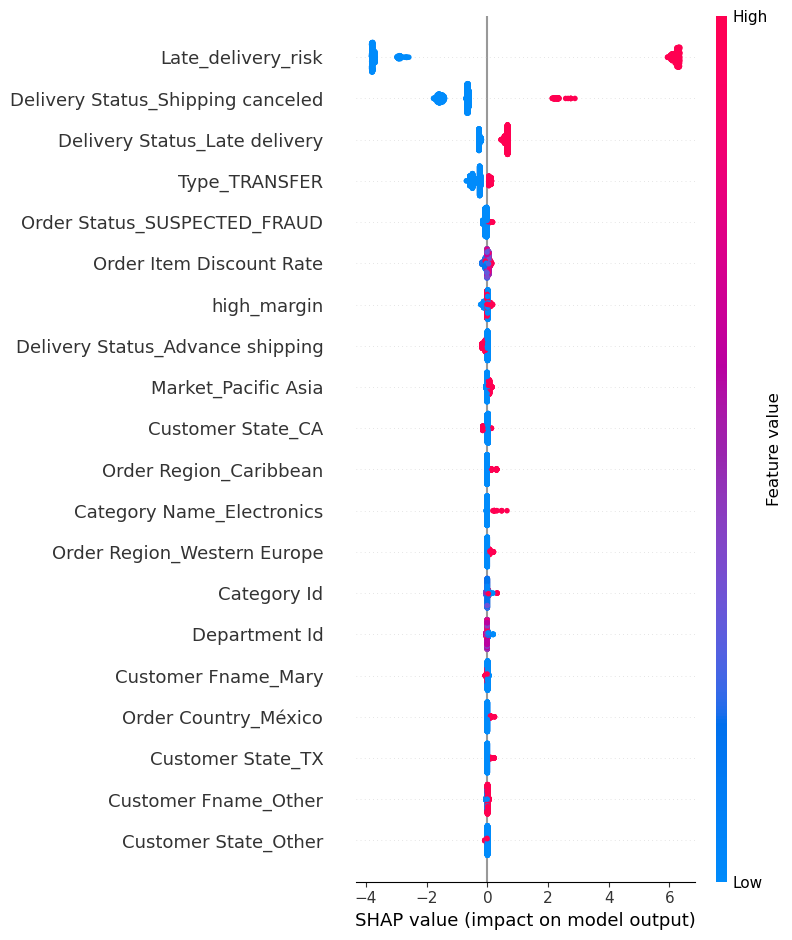

In [34]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


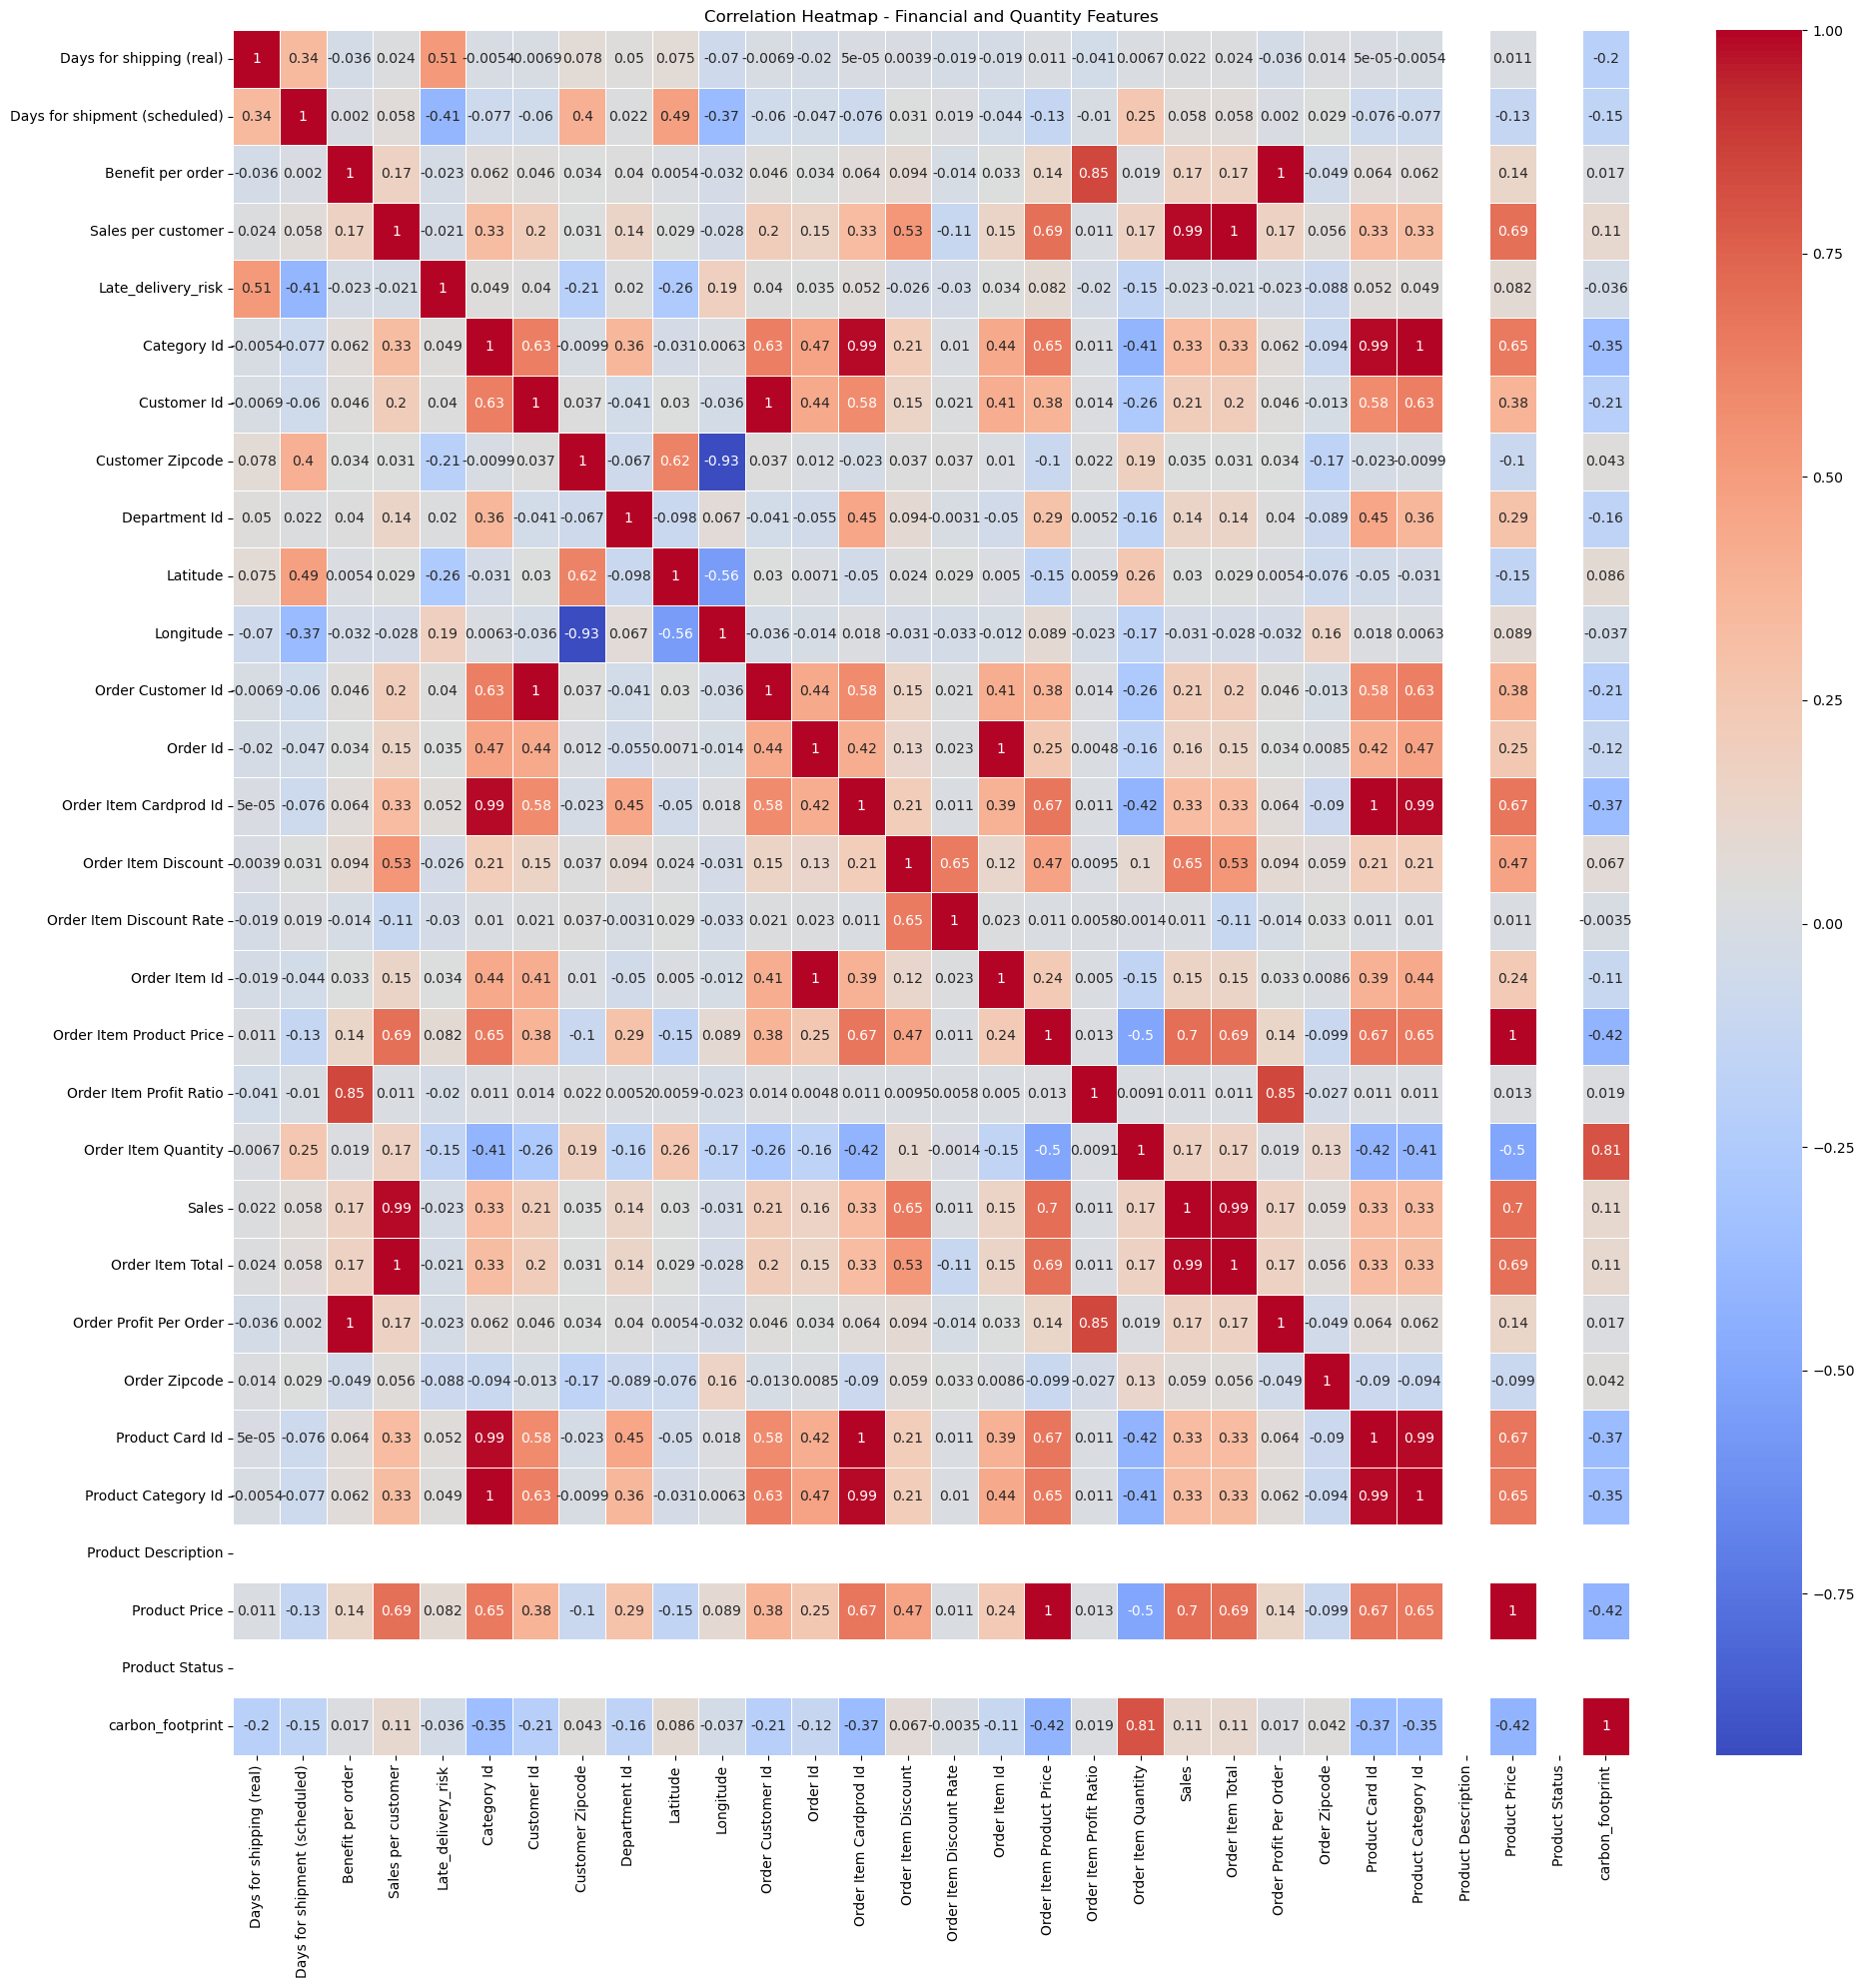

In [35]:
# Correlation Heatmap (Numeric Features)

plt.figure(figsize=(20, 20))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap - Financial and Quantity Features")
plt.tight_layout()
plt.show()

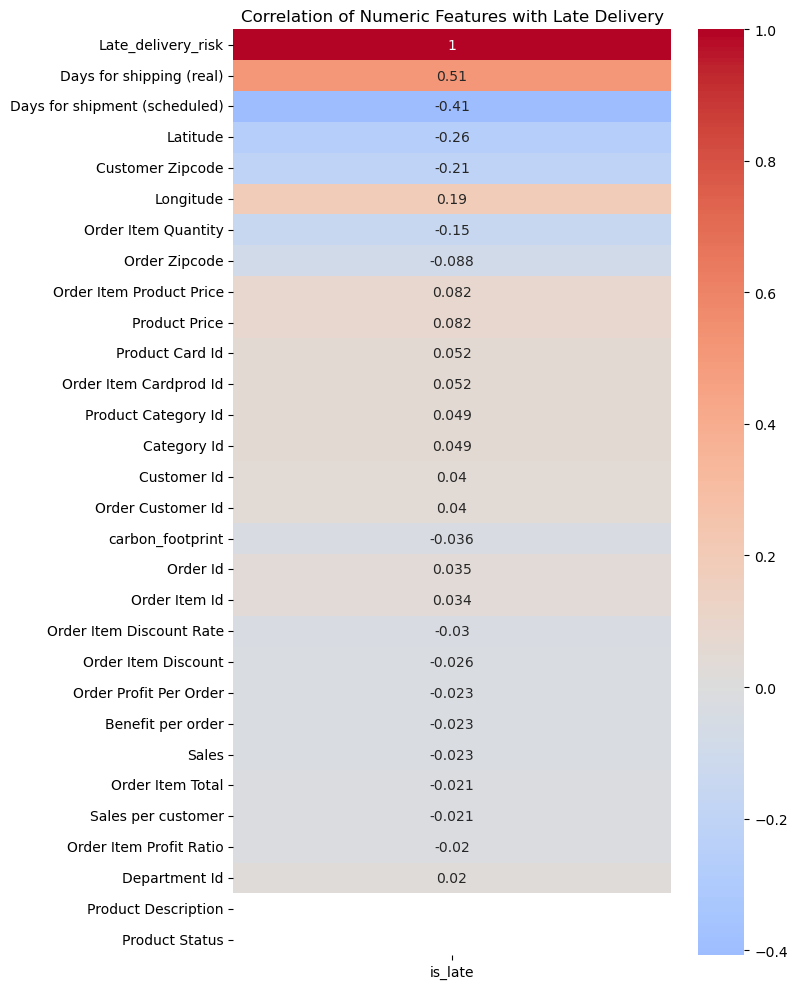

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a Target Variable
# (if not already created, otherwise skip)
df['is_late'] = np.where(df['Delivery Status'].str.lower().str.contains('late'), 1, 0)

# Step 2: Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Step 3: Create a new DataFrame with numeric features + target
numeric_cols['is_late'] = df['is_late']  # make sure target is included

# Step 4: Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Step 5: Focus on correlation with the target
corr_with_target = corr_matrix[['is_late']].drop('is_late')  # drop self-correlation

# Step 6: Sort by strongest absolute correlation
corr_with_target = corr_with_target.reindex(corr_with_target['is_late'].abs().sort_values(ascending=False).index)

# Step 7: Plot
plt.figure(figsize=(8, 10))
sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of Numeric Features with Late Delivery")
plt.tight_layout()
plt.show()


In [38]:
# If we intervene early on predicted late orders
carbon_saved = df[df['is_late'] == 1]['carbon_footprint'].sum() * 0.3  # assuming 30% extra CO₂ if no action

print(f"Estimated Carbon Emissions Saved: {carbon_saved:.2f} kg CO₂")


Estimated Carbon Emissions Saved: 426.29 kg CO₂


In [39]:
# Example: Assume each delayed order costs $10 refund
potential_savings = df[df['is_late'] == 1].shape[0] * 10

print(f"Potential Savings from Early Action: ${potential_savings}")


Potential Savings from Early Action: $25280


In [40]:
# Example: Calculate how many deliveries could be saved from delay
prevented_deliveries = int(df[df['is_late'] == 1].shape[0] * 0.6)  # Assume 60% success rate

print(f"Estimated Successful On-Time Deliveries After Action: {prevented_deliveries} orders")


Estimated Successful On-Time Deliveries After Action: 1516 orders
